# Holland (1980) profile fit on SAR data
The SAR data grid is already centered on the TC center found by the method of Léo.

We use a Holland wind profile, as presented by Holland in his 1980's paper.

If we fix Rmax and let the other parameters vary, the results are really bad. So Rmax must be a free parameter. 


Same if we fix Vmin.

If we fix Vmax however, the results are not so bad. But the goal is to let (Rmax, Vmax) vary as it transcribe (A, B) parameters. So we'd better fix pn and/or pc. 

We constrain Rmax > 5km for the fitted profile, which works well for a lot of TCs.


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit

import functions as f

In [2]:
### PATHS
# dir_path  = '/home/arthur/data/cyclobs/ggd/'
dir_path  = '/home/arthur/data/cyclobs/rotated_files/'
# file_path = 's1b-iw-owi-cm-20170923t104349-20170923t104554-000003-00D45F_ll_gd_rotated.nc'
# file_path = 'rs2--owi-cm-20120928t095127-20120928t095327-00003-BDBE0_ll_gd_rotated.nc'
# NAN BUG (because no wind speed value after r = 400 km, we have to stop the dataset there) file_path = 'rs2--owi-cm-20130701t104119-20130701t104235-00003-79BFE_ll_gd_rotated.nc'
# file_path = 's1a-ew-owi-cm-20180201t132219-20180201t132527-000003-022E2F_ll_gd_rotated.nc'

# Compare with Alexis'
# file_path = 's1a-ew-owi-cm-20180808t041303-20180808t041507-000003-0283BF_ll_gd_rotated.nc' # 2
# file_path = 's1a-ew-owi-cm-20180807t154302-20180807t154506-000003-028386_ll_gd_rotated.nc' # 3
# file_path = 's1a-ew-owi-cm-20180818t150300-20180818t150604-000003-0288C3_ll_gd_rotated.nc' # 4
# file_path = 's1a-ew-owi-cm-20180819t032959-20180819t033303-000003-0288F7_ll_gd_rotated.nc' # 5
# file_path = 's1a-ew-owi-cm-20190731t034721-20190731t034910-000003-033442_ll_gd_rotated.nc' # 6
# file_path = 's1b-ew-owi-cm-20180810t165606-20180810t165822-000003-0167B7_ll_gd_rotated.nc' # 7

# LANE
file_path = 's1a-ew-owi-cm-20180818t150300-20180818t150604-000003-0288C3_ll_gd_rotated.nc'

# TEST
file_path = 's1b-ew-owi-cm-20180902t143708-20180902t143912-000003-01720F_ll_gd_rotated.nc'

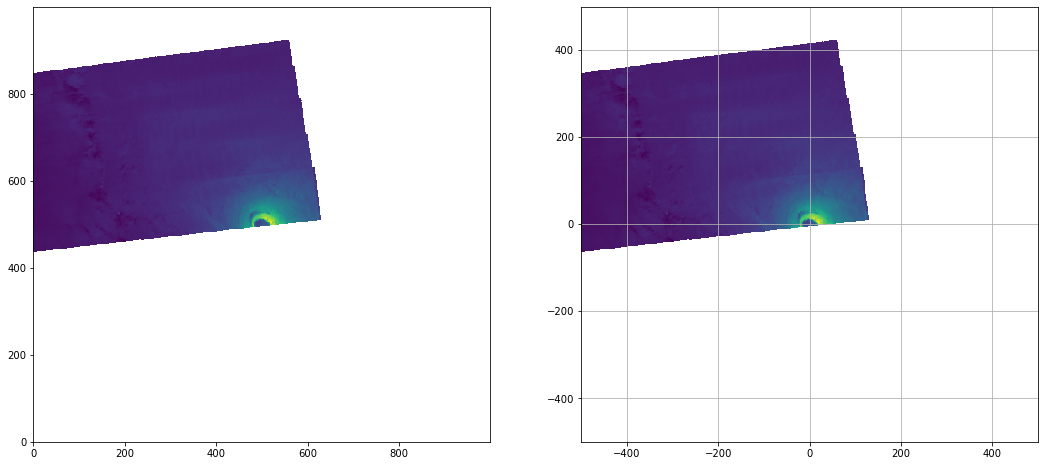

In [3]:
### OPEN AND PRINT
ds = xr.open_dataset(dir_path + file_path)
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.pcolormesh(ds['x'], ds['y'], ds['wind_speed'])
plt.subplot(1, 2, 2)
plt.pcolormesh(ds['x_coords'], ds['y_coords'], ds['wind_speed']);plt.grid()

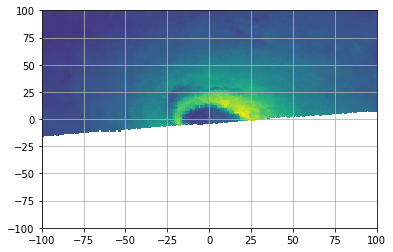

In [4]:
### TEST
plt.pcolormesh(ds['x_coords'], ds['y_coords'], ds['wind_speed'])
plt.axis([-100,100,-100,100]);plt.grid()

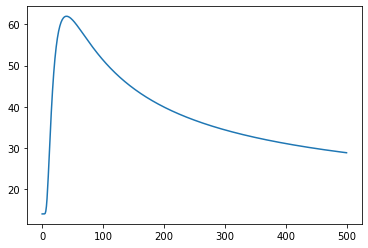

In [5]:
### DEFINE PROFILE FUNCTION
# First define latitude as a global variable, used in the Holland function:
def holland_profile(r, Lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3, and that f is constant and taken at 20° latitude'''
    fcor  = f.coriolis(Lat)
    rho   = 1.15
    B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    V   = r * 0.
    V   = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

# Print the shape
r   = np.arange(501) + 0.001 # To avoid dividing by zero
V   = holland_profile(r, Lat=20., pn=1005 * 100., pc=950 * 100., Vmin=14, Rmax=40, Vmax=48) 
plt.plot(r, V)

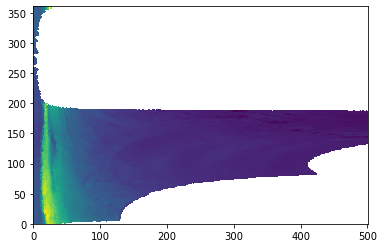

In [6]:
### DEFINE (r, theta) GRID
r     = np.arange(501)
th    = np.arange(361)
r, th = np.meshgrid(r, th)
ds_r  = np.array(ds['r_polar'])

ds_th = np.mod(np.array(ds['theta']) * 180. / np.pi, 360) # convert theta from radians to degrees
ds_ws = np.array(ds['wind_speed'])
# Possible to call griddata() without using meshgrid() before? 
spd   = griddata((ds_r.flatten(), ds_th.flatten()), ds_ws.flatten(), (r, th), method='nearest')

plt.pcolormesh(spd)

Initialization values ==> 100500.0 ,  95000.0 ,  21.33 ,  19 ,  63.78
Final values ========> [9.956532e+04 9.592835e+04 5.830000e+00 2.017000e+01 5.137000e+01]


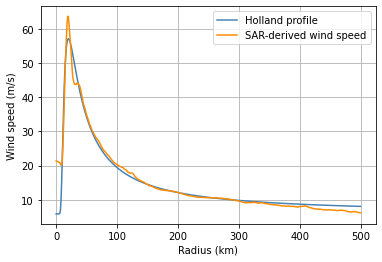

In [7]:
### FITTING THE PROFILE
# Initializing the values
radius = np.arange(501) + .0001 # to avoid having both r = 0 and n < 0 during fitting process
spdm   = np.nanmean(spd, axis=0)
Lat    = np.float64(ds['lat_ref']) #[°]         latitude of storm center
pn     = 1005 * 100. # to convert mbar pressures in Pa pressures
pc     = 950 * 100.  # to convert mbar pressures in Pa pressures
Vmin   = spdm[0] # 14
Rmax   = np.argmax(spdm[:100]) # 40
if Rmax < 5:
    Rmax = 5
Vmax   = np.max(spdm[:100]) # 48
# Latitude of storm center is defined above as a global variable to enter the holland_prfile() function

# Fit profile to data
print("Initialization values ==>", pn, ", ", pc, ", ", "{:.2f}".format(Vmin), ", ", Rmax, ", ", "{:.2f}".format(Vmax))
popt, pcov = curve_fit(lambda radius, pn, pc, Vmin, Rmax, Vmax: holland_profile(radius, Lat, pn, pc, Vmin, Rmax, Vmax), radius, spdm, p0=[pn, pc, Vmin, Rmax, Vmax], bounds=((850 * 100, 850 * 100, 0, 5, 0), (1100 * 100, 1100 * 100, 50, 500, 200))) # Lat is fixed
print("Final values ========>", np.around(popt, decimals=2)) # Caveat: Real VMAX = Vmax + Vmin

# Print the results
V_fit = holland_profile(radius, Lat, popt[0], popt[1], popt[2], popt[3], popt[4])
fig1  = plt.plot(radius, V_fit, color='steelblue', label='Holland profile')      # V_fit
fig2  = plt.plot(radius, spdm,  color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()

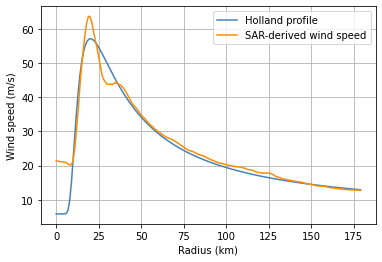

In [8]:
### SMALLER SCALE
fig1 = plt.plot(radius[:180], V_fit[:180], color='steelblue', label='Holland profile')            # V_fit
fig2 = plt.plot(radius[:180], spdm[:180],   color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()
# plt.savefig('profil.png')
plt.show()

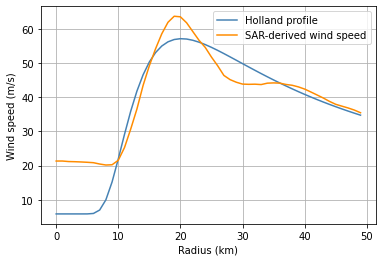

In [9]:
### EVEN SMALLER SCALE
fig1 = plt.plot(radius[:50], V_fit[:50], color='steelblue', label='Holland profile')            # V_fit
fig2 = plt.plot(radius[:50], spdm[:50],   color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()
# plt.savefig('profil.png')
plt.show()